In [1]:
#import our useful libraries
import numpy as np
import pandas as pd 
import tensorflow as tf 
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [2]:
# this function to produce the Rna which not a cause of disease 
def produce_negative_data(data,sample_num,num_lncRNA):
    negative_data = pd.DataFrame(columns=['Rna_id','Disease Name','label'])
    total_lncRNA = set(i for i in range(num_lncRNA))
    grouped = data.groupby('Disease Name')
    for name,group in grouped:
        lncRNA = set(group['Rna_id'])
        num_positive = len(lncRNA)
        disease = set(group['Disease Name'])
        lncRNA = total_lncRNA - lncRNA
        df = pd.DataFrame(columns=['Rna_id','Disease Name','label'])
        df['Rna_id'] = random.sample(lncRNA,min(num_positive*sample_num,len(lncRNA)))
        df['Disease Name'] = list(disease)*min(num_positive*sample_num,len(lncRNA))
        df['label'] = [0] * min(num_positive*sample_num,len(lncRNA))
        negative_data = negative_data.append(df,ignore_index=True)
    return data.append(negative_data,ignore_index=True)

In [3]:
data = pd.read_csv("/content/pre_data.csv")# read data
use_data = data[['Rna_id','ncRNA Category','Species','Disease Name']]
use_data = use_data[use_data['ncRNA Category'] == 'lncRNA']
use_data = use_data[use_data['Species'] == 'Homo sapiens']
use_data = use_data[['Rna_id','Disease Name']]# take our two important columns
use_data.drop_duplicates(inplace=True)#to avoid duplication in our data 

In [4]:
data.columns

Index(['Unnamed: 0', 'Rna_id', 'Sequence', 'ncRNA Category', 'Disease Name',
       'Dysfunction Pattern', 'Species', 'Anti_Sequence'],
      dtype='object')

In [5]:

lncRNA_shift = {}
disease_shift = {}
cnt_lncRNA = 0
for each_lncRNA in sorted(list(set(use_data['Rna_id']))):# make for any unique Rna_id a number instead of text
    lncRNA_shift[each_lncRNA] = cnt_lncRNA
    cnt_lncRNA += 1# the count the total number of Rna_id
#we do the same thing for Disease Name 
cnt_disease = 0
for each_disease in sorted(list(set(use_data['Disease Name']))):
    disease_shift[each_disease] = cnt_disease
    cnt_disease += 1

In [6]:
use_data['Rna_id'] = use_data['Rna_id'].apply(lambda x:lncRNA_shift[x])
use_data['Disease Name'] = use_data['Disease Name'].apply(lambda x:disease_shift[x])
use_data['label'] = 1
tran_data = use_data
tran_data = produce_negative_data(tran_data, 4, cnt_lncRNA)

In [7]:
cnt_RNA = len(tran_data['Rna_id'].unique())#numbe of unique values in rna_id
cnt_disease = len(tran_data['Disease Name'].unique())#for disease 

In [8]:
input_disease = tf.keras.Input(shape=(1,), dtype="int32")# the input of our model
input_RNA = tf.keras.Input(shape=(1,), dtype="int32")
# the embedding of disease and Rna , to capture the semantics of inputs 
disease_embd = tf.keras.layers.Embedding(cnt_disease, 
                                         32, 
                                         embeddings_initializer=tf.keras.initializers.GlorotNormal() ) (input_disease)
RNA_embd = tf.keras.layers.Embedding(cnt_RNA, 
                                         32, 
                                         embeddings_initializer=tf.keras.initializers.GlorotNormal() ) (input_RNA)
#concatenation of our two embedding values 
concat_embd = tf.keras.layers.Concatenate()([disease_embd, RNA_embd])
# the first layer with 32 neurons and relu activation , uniform initialization 
layer_1 = tf.keras.layers.Dense(
    32,
    activation='relu',
    use_bias=True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
)(concat_embd)
# the first layer with 16 neurons and relu activation , uniform initialization 
layer_2 = tf.keras.layers.Dense(
    16,
    activation='relu',
    use_bias=True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
)(layer_1)
# the first layer with 8 neurons and relu activation , uniform initialization 
layer_3 = tf.keras.layers.Dense(
    8,
    activation='relu',
    use_bias=True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
)(layer_2)
#multiplication fo the two embedding values
embed_multiply =  tf.keras.layers.Multiply()([disease_embd, RNA_embd])
concat_2 = tf.keras.layers.Concatenate()([layer_3, embed_multiply])
output = tf.keras.layers.Dense(
    1,
    activation='sigmoid',
    use_bias=True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
)(concat_2)


model = tf.keras.Model(inputs=[input_disease, input_RNA], outputs=output)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 32)        1216        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 32)        68672       input_2[0][0]                    
______________________________________________________________________________________________

In [10]:
from keras.utils.vis_utils import plot_model

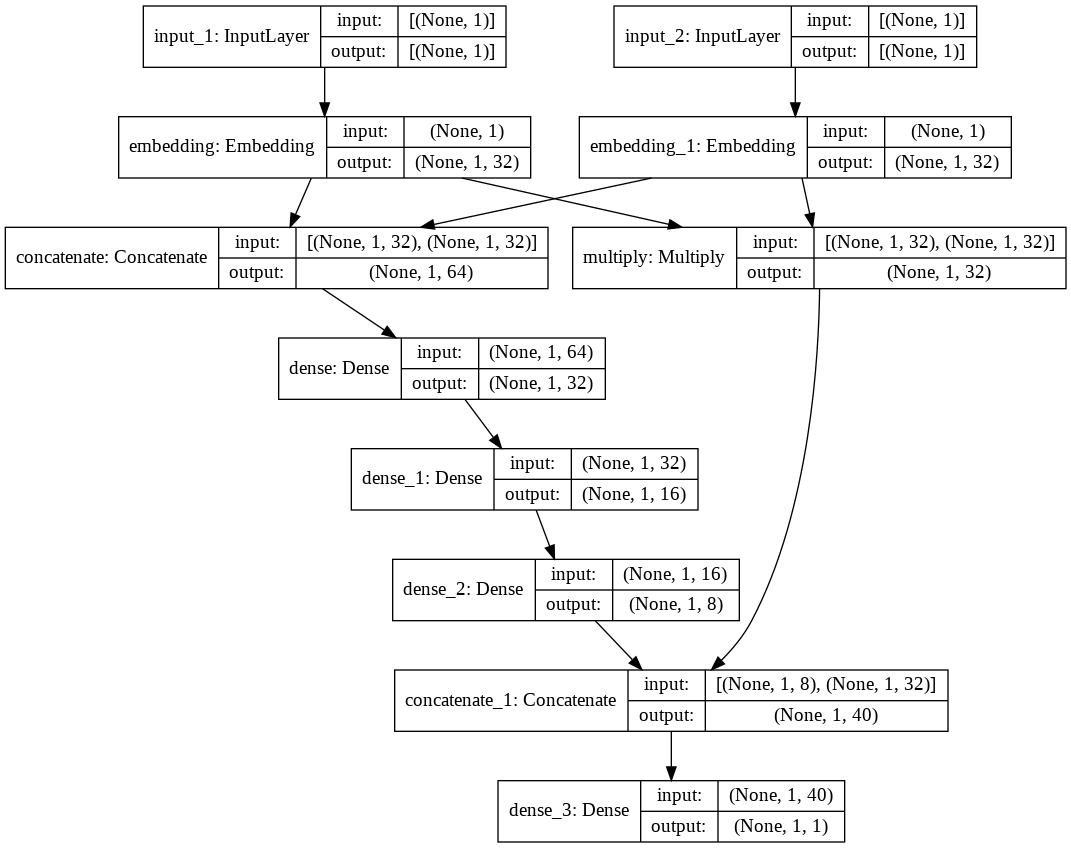

In [11]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
#compilation with Adam optimizer and binary cross entropy because we predict a binary output Rna is cause of this disease or not 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.binary_accuracy])

In [13]:
Rna_id_to_seq = data[['Rna_id', 'Sequence']].drop_duplicates().set_index('Rna_id').to_dict()['Sequence']

In [14]:
model.fit([tran_data['Disease Name'].values.astype("int32"), tran_data['Rna_id'].values.astype("int32")], tran_data['label'].values.astype("int32"),
          batch_size=1024, epochs=100, validation_split=0.2)

Epoch 1/100
38/38 [==============================] - 2s 22ms/step - loss: 0.6813 - binary_accuracy: 0.6213 - val_loss: 0.6580 - val_binary_accuracy: 0.8544
Epoch 2/100
38/38 [==============================] - 0s 6ms/step - loss: 0.6251 - binary_accuracy: 0.6685 - val_loss: 0.8678 - val_binary_accuracy: 0.1714
Epoch 3/100
38/38 [==============================] - 0s 5ms/step - loss: 0.4934 - binary_accuracy: 0.7723 - val_loss: 1.6063 - val_binary_accuracy: 0.1491
Epoch 4/100
38/38 [==============================] - 0s 5ms/step - loss: 0.3757 - binary_accuracy: 0.8230 - val_loss: 2.3069 - val_binary_accuracy: 0.0735
Epoch 5/100
38/38 [==============================] - 0s 5ms/step - loss: 0.3532 - binary_accuracy: 0.8337 - val_loss: 3.0224 - val_binary_accuracy: 0.0536
Epoch 6/100
38/38 [==============================] - 0s 5ms/step - loss: 0.3387 - binary_accuracy: 0.8449 - val_loss: 3.5877 - val_binary_accuracy: 0.0529
Epoch 7/100
38/38 [==============================] - 0s 5ms/step - lo

In [15]:

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

In [16]:
del model  # deletes the existing model

In [17]:
from keras.models import load_model

In [18]:
# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 32)        1216        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 32)        68672       input_2[0][0]                    
______________________________________________________________________________________________

In [20]:
[tran_data['Disease Name'].values[-30:].astype("int32"), tran_data['Rna_id'].values[-30:].astype("int32")]

[array([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37], dtype=int32),
 array([1286, 1942,  481, 1032,  387, 2109, 1315,  294,  790,  244, 1337,
         369,  594,  916,   54,  755,  416,  414,  260, 1947, 1303,   99,
        1131, 1178, 1630,  105, 1652,  593, 1149, 1911], dtype=int32)]

In [21]:
model.predict([tran_data['Disease Name'].values[-30:].astype("int32"), tran_data['Rna_id'].values[-30:].astype("int32")])

array([[[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[0.9999183]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]],

       [[1.       ]]], dtype=float32)

In [22]:
len(lncRNA_shift)

2146

In [23]:
data.head(3)

,Unnamed: 0,Rna_id,Sequence,ncRNA Category,Disease Name,Dysfunction Pattern,Species,Anti_Sequence
0,0,hsa-let-7a-3p,CUAUACAAUCUACUGUCUUUC,lncRNA,prostate cancer,Regulation [down-regulated],Homo sapiens,NaN
1,1,hsa-let-7a-3p,CUAUACAAUCUACUGUCUUUC,lncRNA,colon cancer,Regulation [down-regulated],Homo sapiens,NaN
2,2,hsa-let-7a-3p,CUAUACAAUCUACUGUCUUUC,lncRNA,colon cancer,Regulation [up-regulated],Homo sapiens,GAUAUGUUAGAUGACAGAAAG


In [24]:
is_upregulated_dict = dict(zip(data['Rna_id'], data['Dysfunction Pattern'].apply(lambda x: 'up-regulated' in x) ) ) 

In [25]:
Rna_id_to_seq = data[['Rna_id', 'Sequence']].drop_duplicates().set_index('Rna_id').to_dict()['Sequence']
invere_lncRNA_shift = dict(map(reversed, lncRNA_shift.items()))

Rna_id_to_antiseq = data[['Rna_id', 'Anti_Sequence']].drop_duplicates().set_index('Rna_id').to_dict()['Anti_Sequence']


In [26]:
model = load_model('my_model.h5')
diseas_name = input("Please enter the name of the type of cancer you need to predict: ")
if (diseas_name not in disease_shift):
    print("error: Incorrect cancer name")
else:
    print( "Begin predict")
    cnt = disease_shift[diseas_name]
    desease_ids = np.array( [0]*len(lncRNA_shift) )
    rna_ids = np.array( list(lncRNA_shift.values()) )

    propas = model.predict([desease_ids, rna_ids])

    results_df = pd.DataFrame()
    results_df['rna_ids'] = rna_ids
    results_df['propa'] = propas[:, 0][:, 0]
    results_df['desease name'] = diseas_name

    results_df['lncRNA'] = results_df['rna_ids'].apply(lambda x: invere_lncRNA_shift[x])
    results_df['lncRNA sequence'] = results_df['lncRNA'].apply(lambda x: Rna_id_to_seq[x])
    results_df['Dysfunction Pattern']= results_df['lncRNA'].apply(lambda x: 'UP regulated' if is_upregulated_dict[x] else 'Down regulated')
    results_df['Anti_Sequence']=  results_df['lncRNA'].apply(lambda x: Rna_id_to_antiseq[x] if is_upregulated_dict[x] else '')
    

    short_result  = results_df[results_df['propa'] > 0.5]# the rna id which caused this disease with a probability more than 50%
    short_result  = short_result.sort_values(by=['propa'],ascending=False)
    short_result.to_csv(input('Enter name for results file:'))
    print ('Done! check the results file')



Please enter the name of the type of cancer you need to predict: breast cancer
Begin predict
Enter name for results file:breast cancer
Done! check the results file


In [27]:
Rna_id_to_seq

{'hsa-let-7a-3p': 'CUAUACAAUCUACUGUCUUUC',
 'hsa-let-7g-5p': 'UGAGGUAGUAGUUUGUACAGUU',
 'hsa-miR-17-5p': 'CAAAGUGCUUACAGUGCAGGUAG',
 'hsa-miR-142-5p': 'CAUAAAGUAGAAAGCACUACU',
 'hsa-miR-198': 'GGUCCAGAGGGGAGAUAGGUUC',
 'hsa-miR-107': 'AGCAGCAUUGUACAGGGCUAUCA',
 'hsa-miR-142-3p': 'UGUAGUGUUUCCUACUUUAUGGA',
 'hsa-miR-17-3p': 'ACUGCAGUGAAGGCACUUGUAG',
 'hsa-miR-184': 'UGGACGGAGAACUGAUAAGGGU',
 'hsa-miR-206': 'UGGAAUGUAAGGAAGUGUGUGG',
 'hsa-miR-346': 'UGUCUGCCCGCAUGCCUGCCUCU',
 'hsa-miR-133b': 'UUUGGUCCCCUUCAACCAGCUA',
 'hsa-miR-324-5p': 'CGCAUCCCCUAGGGCAUUGGUG',
 'hsa-miR-30e-3p': 'CUUUCAGUCGGAUGUUUACAGC',
 'hsa-miR-422a': 'ACUGGACUUAGGGUCAGAAGGC',
 'hsa-miR-326': 'CCUCUGGGCCCUUCCUCCAG',
 'hsa-miR-30a-5p': 'UGUAAACAUCCUCGACUGGAAG',
 'hsa-miR-30a-3p': 'CUUUCAGUCGGAUGUUUGCAGC',
 'hsa-miR-325': 'CCUAGUAGGUGUCCAGUAAGUGU',
 'hsa-miR-324-3p': 'CCCACUGCCCCAGGUGCUGCUGG',
 'hsa-miR-300': 'UAUACAAGGGCAGACUCUCUCU',
 'hsa-miR-527': 'CUGCAAAGGGAAGCCCUUUC',
 'hsa-miR-520h': 'ACAAAGUGCUUCCCUUUAGAGU',
 '